In [402]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV # 파라미터 search 용

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
random_state = 2020

In [403]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data2'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data2/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data2/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [404]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [405]:
price = train['price']

del train['price']

In [406]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인<br>
missingno 라이브러리의 matrix 함수를 사용하여 데이터의 결측 상태를 시각화

<AxesSubplot:>

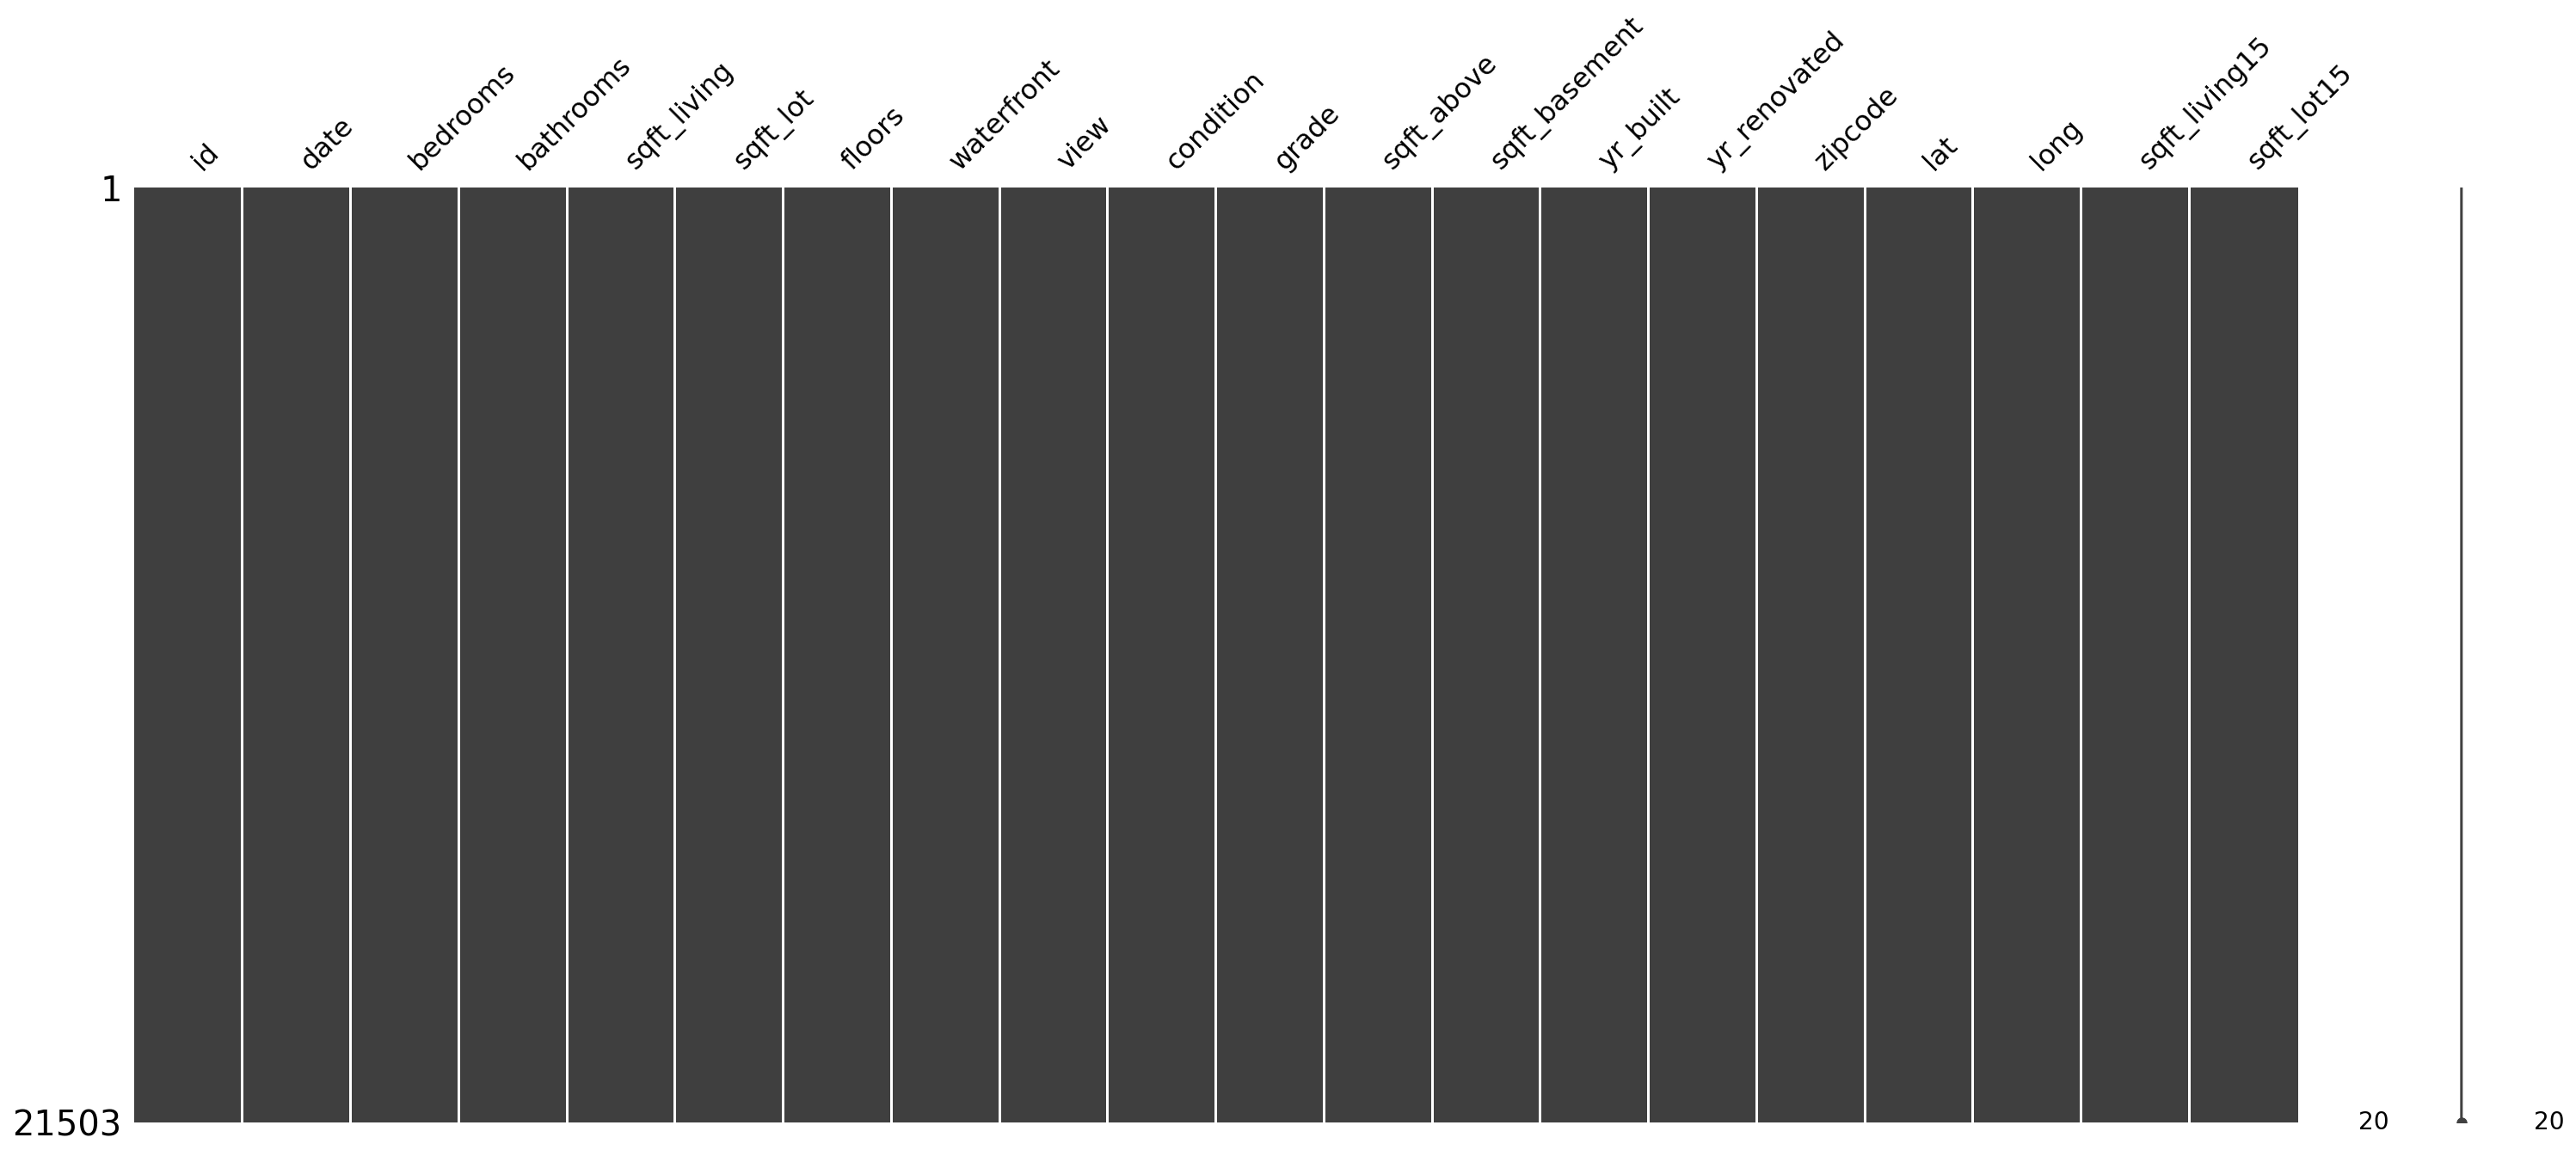

In [407]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보인다<br>

In [408]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [409]:
train_id = data['id'][:train_len]
test_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

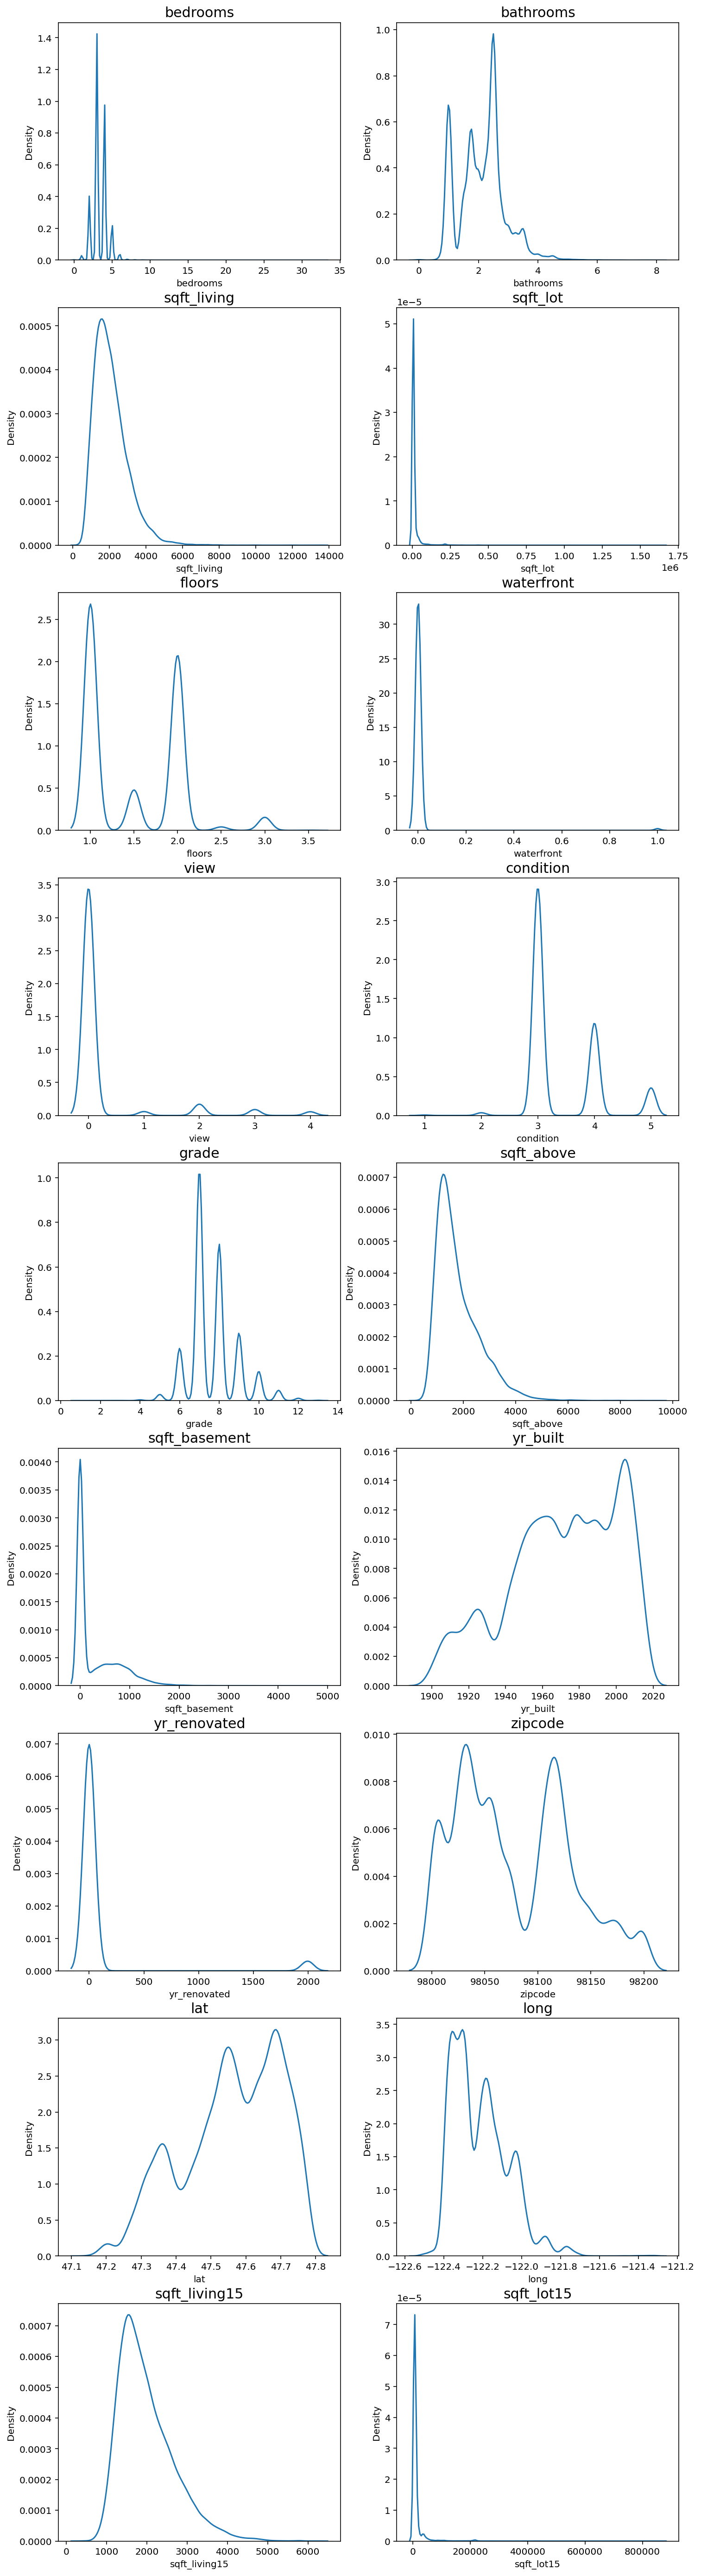

In [410]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

* 한쪽으로 치우친 그래프의 형태를 보이는 변수들에 대해 정규화를 시켜준다

In [411]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15', 'waterfront', 'view']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

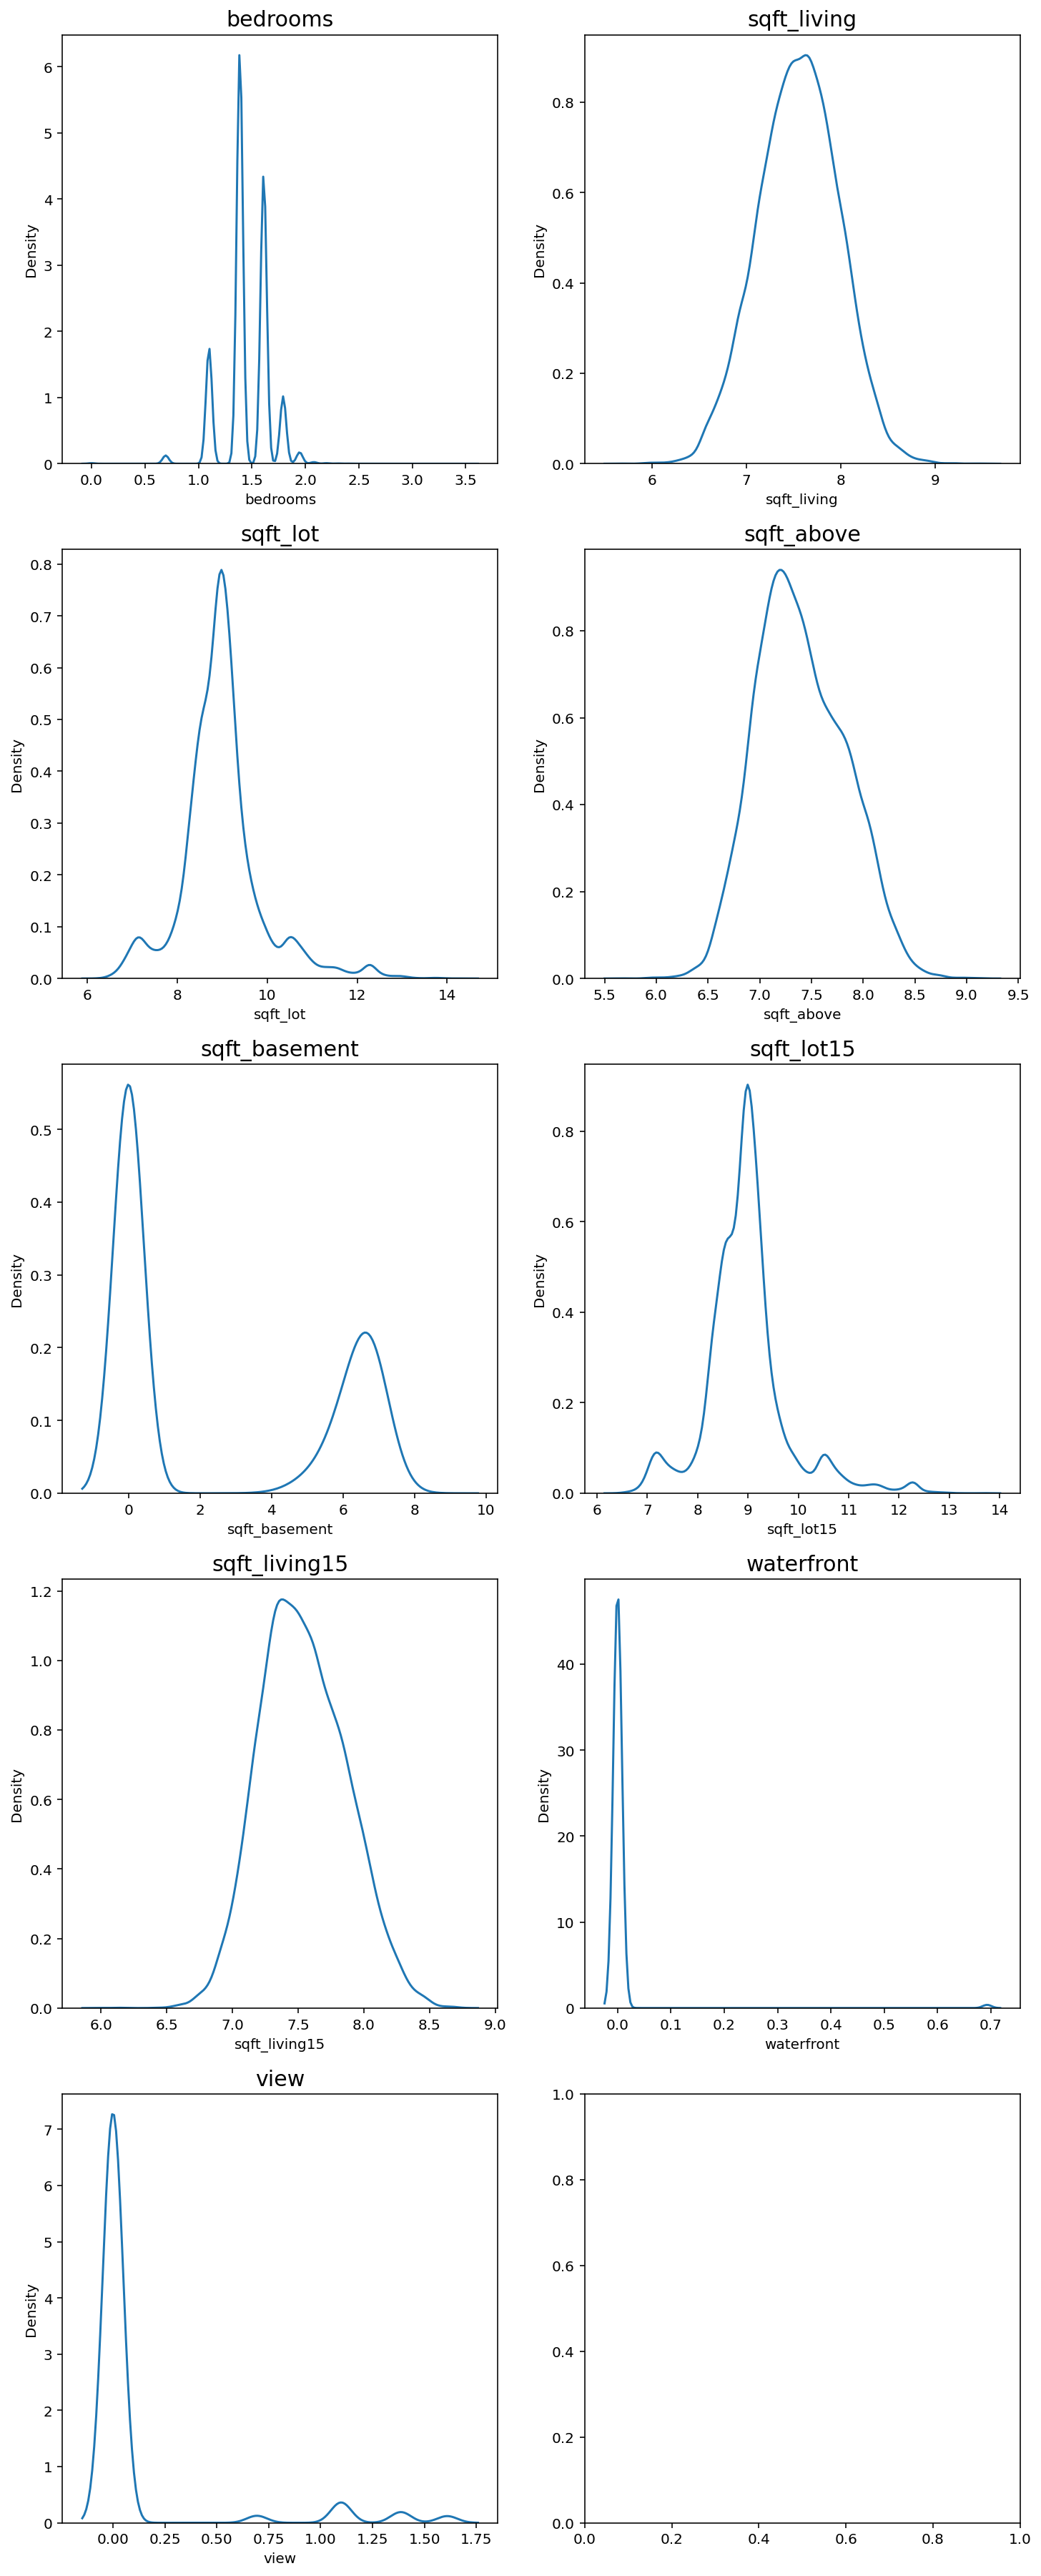

In [412]:
fig, ax = plt.subplots(5, 2, figsize=(12, 32))

count = 0
for row in range(5):
    for col in range(2):
        if count == 9:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

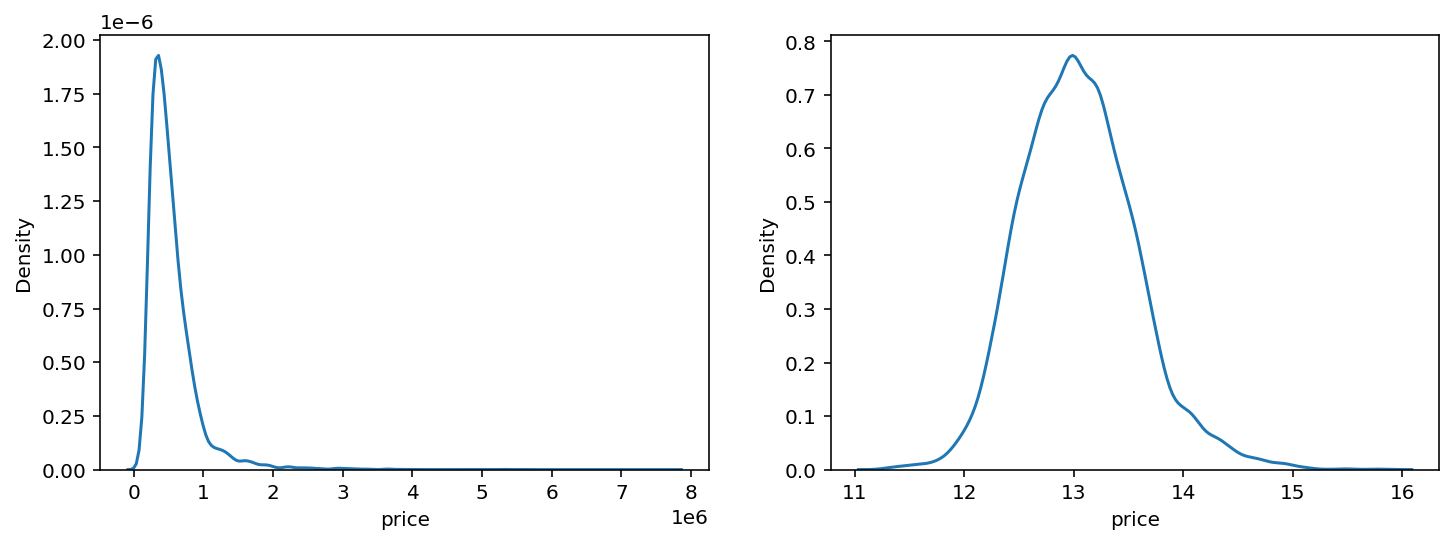

In [413]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(price, ax=ax[0])
log_price = np.log1p(price)
sns.kdeplot(log_price, ax=ax[1]);

* price에 대해서도 마찬가지로 정규화를 시켜준다

<AxesSubplot:>

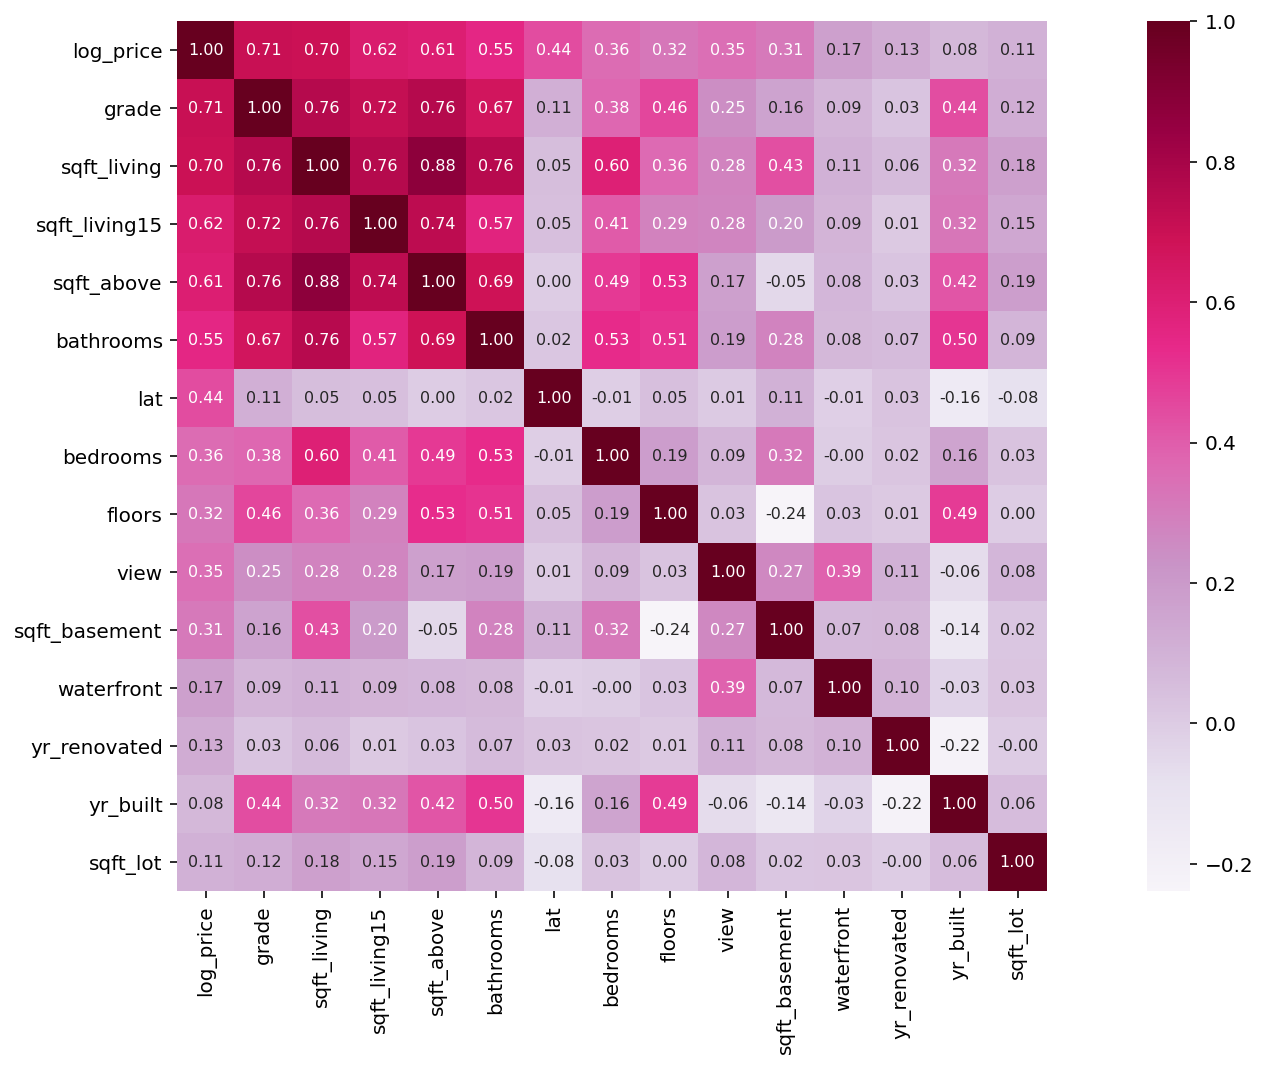

In [414]:
# saleprice correlation matrix
train['log_price']=log_price
h_num = 15 # number of variables for heatmap
corr_mat = abs(train.corr(method='spearman')) # 각 feature간의 correlationn 결과 확인
cols = corr_mat.nlargest(h_num, 'log_price').index # nlargest : 'price'에 대한 가장 큰 값을 가지는 feature 15개를 return
cm = np.corrcoef(train[cols].values.T) # correlation 특정 칼럼에 대해서

# correlation 값에 대한 heatmap 출력
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(data=cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':8}, yticklabels=cols.values, xticklabels=cols.values, ax=ax, cmap='PuRd')


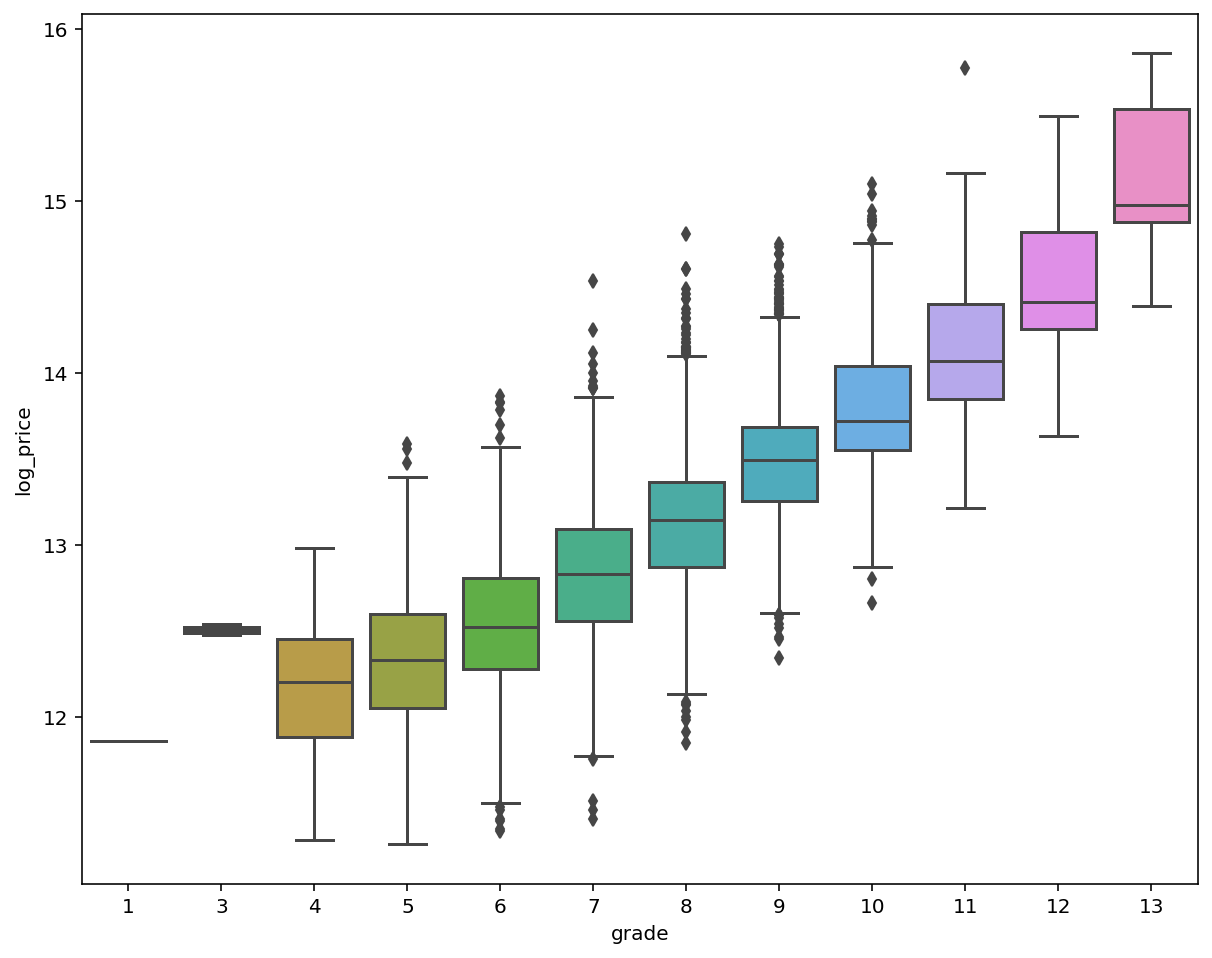

In [415]:
# price와 grade간의 상관관계
tmp_data = pd.concat([train['log_price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=tmp_data, x='grade', y='log_price', ax=ax);

In [416]:
# outlier 값 제거
#train = train.loc[train['id'] != 2775]
#test = test.loc[test['id'] != 2775]

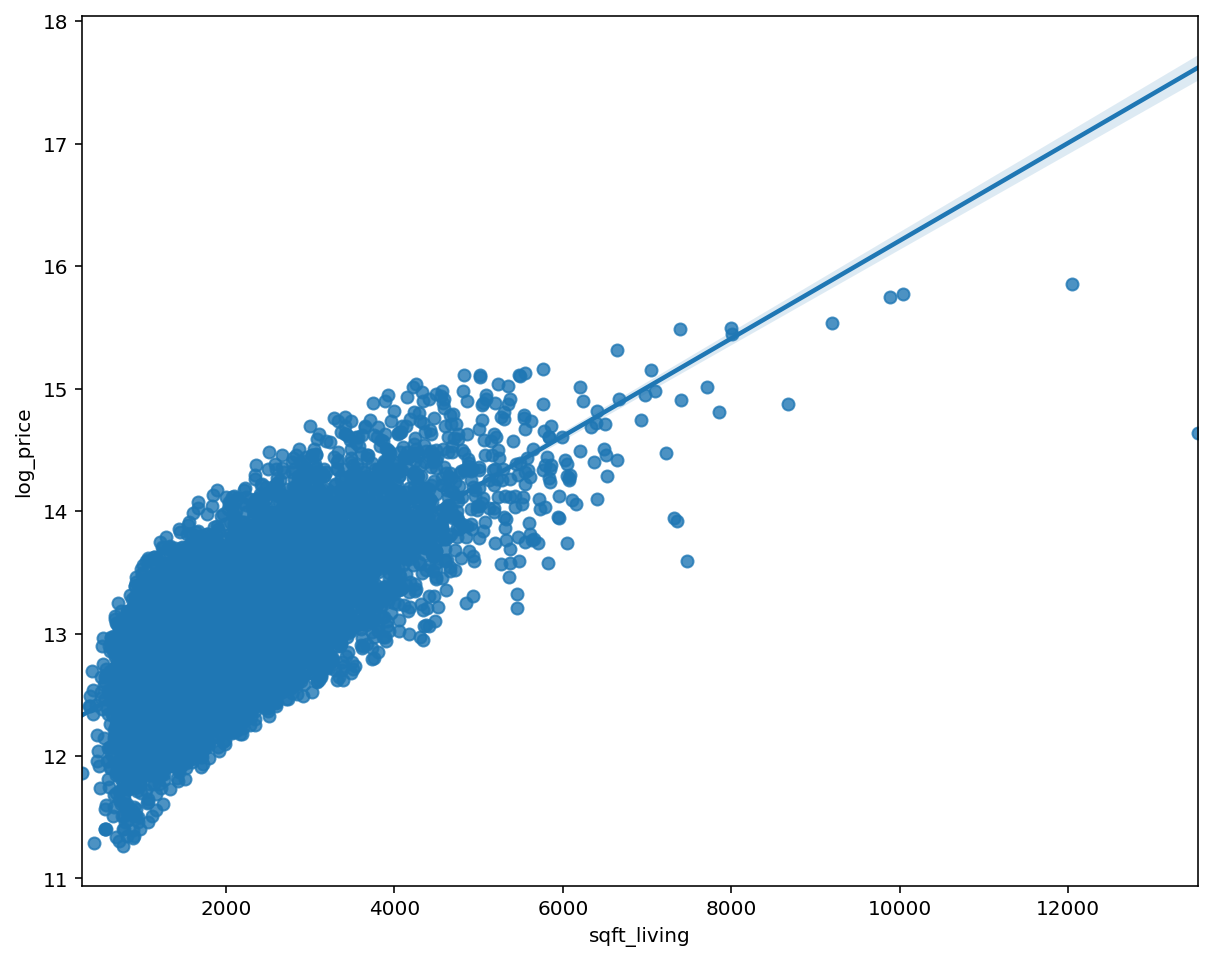

In [417]:
# price와 sqft_living 과의 상관관계
tmp_data = pd.concat([train['sqft_living'], train['log_price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='sqft_living', y='log_price', data=tmp_data, ax=ax);

In [418]:
# outlier 값 제거
#train = train.loc[train['id'] != 8912] # id=8912 drop
#test = test.loc[test['id'] != 8912]

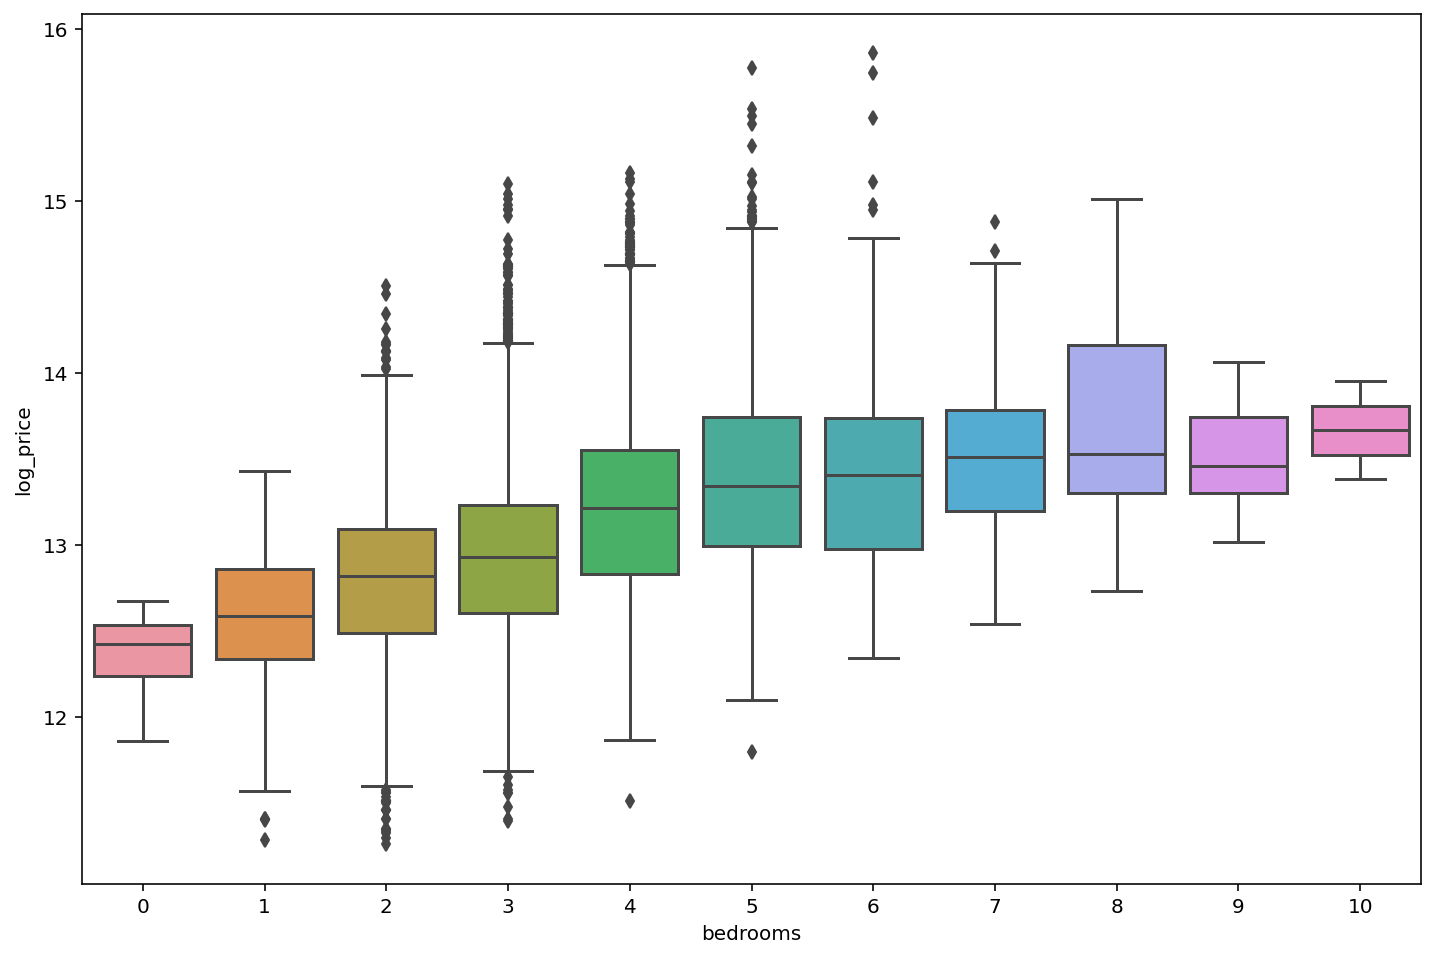

In [419]:
# price와 bedrooms 간의 상관관계 확인
tmp_data = pd.concat([train['bedrooms'], train['log_price']], axis=1)
f, ac = plt.subplots(figsize=(12,8))
sns.boxplot(x='bedrooms', y='log_price', data=tmp_data);

* 몇가지 그래프를 통해 각 column 간의 상관관계 및 outlier를 확인
* 특별히 drop 할 값은 없어 보인다


In [420]:
log_price = train['log_price']
del train['log_price']

In [421]:
train['date'] = pd.to_datetime(train['date']).dt.year
train['year'] = train['date'].astype('int')
del train['date']

test['date'] = pd.to_datetime(test['date']).dt.year
test['year'] = test['date'].astype('int')
del test['date']

* date 정보 중에 year만 따로 column으로 빼둔 뒤 삭제

### LGB, GB model에 대한 GridSearchCV 진행
#### LGB

In [422]:
# 'num_leaves', 'learning_rate', 'n_estimators'에 대한 GridSearchCV 진행

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_params = {
    'num_leaves': (30, 40, 50),
    'learning_rate': (0.01, 0.02, 0.03),
}

lgb_search = GridSearchCV(estimator=lgb.LGBMRegressor(n_estimators=1000, random_state=1), param_grid=lgb_params, cv = 5, scoring='neg_mean_squared_error', verbose=1, n_jobs= -1)
lgb_search.fit(train.values, log_price)

# GridSearchCV score 및 최적 parameter 출력
print(lgb_search.best_score_)
print(lgb_search.best_params_)

# search 결과값 저장
params = lgb_search.cv_results_['params']
score = lgb_search.cv_results_['mean_test_score']
    
# 데이터 프레임 생성
results = pd.DataFrame(params)
results['score'] = score
    
# RMSLE 값 계산 후 정렬
results['RMSLE'] = np.sqrt(-1 * results['score'])
results = results.sort_values('RMSLE')


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   41.8s finished


-0.026329687043502626
{'learning_rate': 0.02, 'num_leaves': 30}


In [423]:
results.head(2)

,learning_rate,num_leaves,score,RMSLE
3,0.02,30,-0.02633,0.162264
6,0.03,30,-0.02638,0.162418


#### GB (GradientBoost)

In [432]:
# learning_rate', 'n_estimators'에 대한 GridSearchCV 진행

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gb_params = {
    'learning_rate': (0.06, 0.07, 0.08)
}

gb_search = GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=1000), param_grid=gb_params, cv = 5, scoring='neg_mean_squared_error', verbose=1, n_jobs= -1)
gb_search.fit(train.values, log_price)

# GridSearchCV score 및 최적 parameter 출력
print(gb_search.best_score_)
print(gb_search.best_params_)

# search 결과값 저장
params = gb_search.cv_results_['params']
score = gb_search.cv_results_['mean_test_score']
    
# 데이터 프레임 생성
results = pd.DataFrame(params)
results['score'] = score
    
# RMSLE 값 계산 후 정렬
results['RMSLE'] = np.sqrt(-1 * results['score'])
results = results.sort_values('RMSLE')


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.0min finished


-0.027872206176849594
{'learning_rate': 0.07}


In [433]:
results.head(2)

,learning_rate,score,RMSLE
1,0.07,-0.027872,0.166950
0,0.06,-0.027986,0.167291


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [434]:
gboost = GradientBoostingRegressor(learning_rate=0.07, n_estimators=1000, random_state=random_state)
lightgbm = lgb.LGBMRegressor(learning_rate=0.02, n_estimators=1000, num_leaves=30, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [435]:
def get_cv_score(models):
    sKfold = StratifiedKFold(n_splits=5, random_state=random_state).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, log_price)), 
                                             kf=sKfold))

In [436]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8993
Model LightGBM CV score : 0.9051


### Make Submission

* LGB, GB 두개의 모델에 대한 결과값을 blending 하여 csv 파일로 출력한다

In [437]:
def AveragingBlending(models, train, price, test):
    for m in models : 
        m['model'].fit(train.values, price)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [438]:
y_pred = AveragingBlending(models, train, log_price, test)

In [439]:
test_result = pd.DataFrame(data={'id':test_id,'price':np.expm1(y_pred)})

In [440]:
test_result.to_csv('submission_price.csv', index=False)

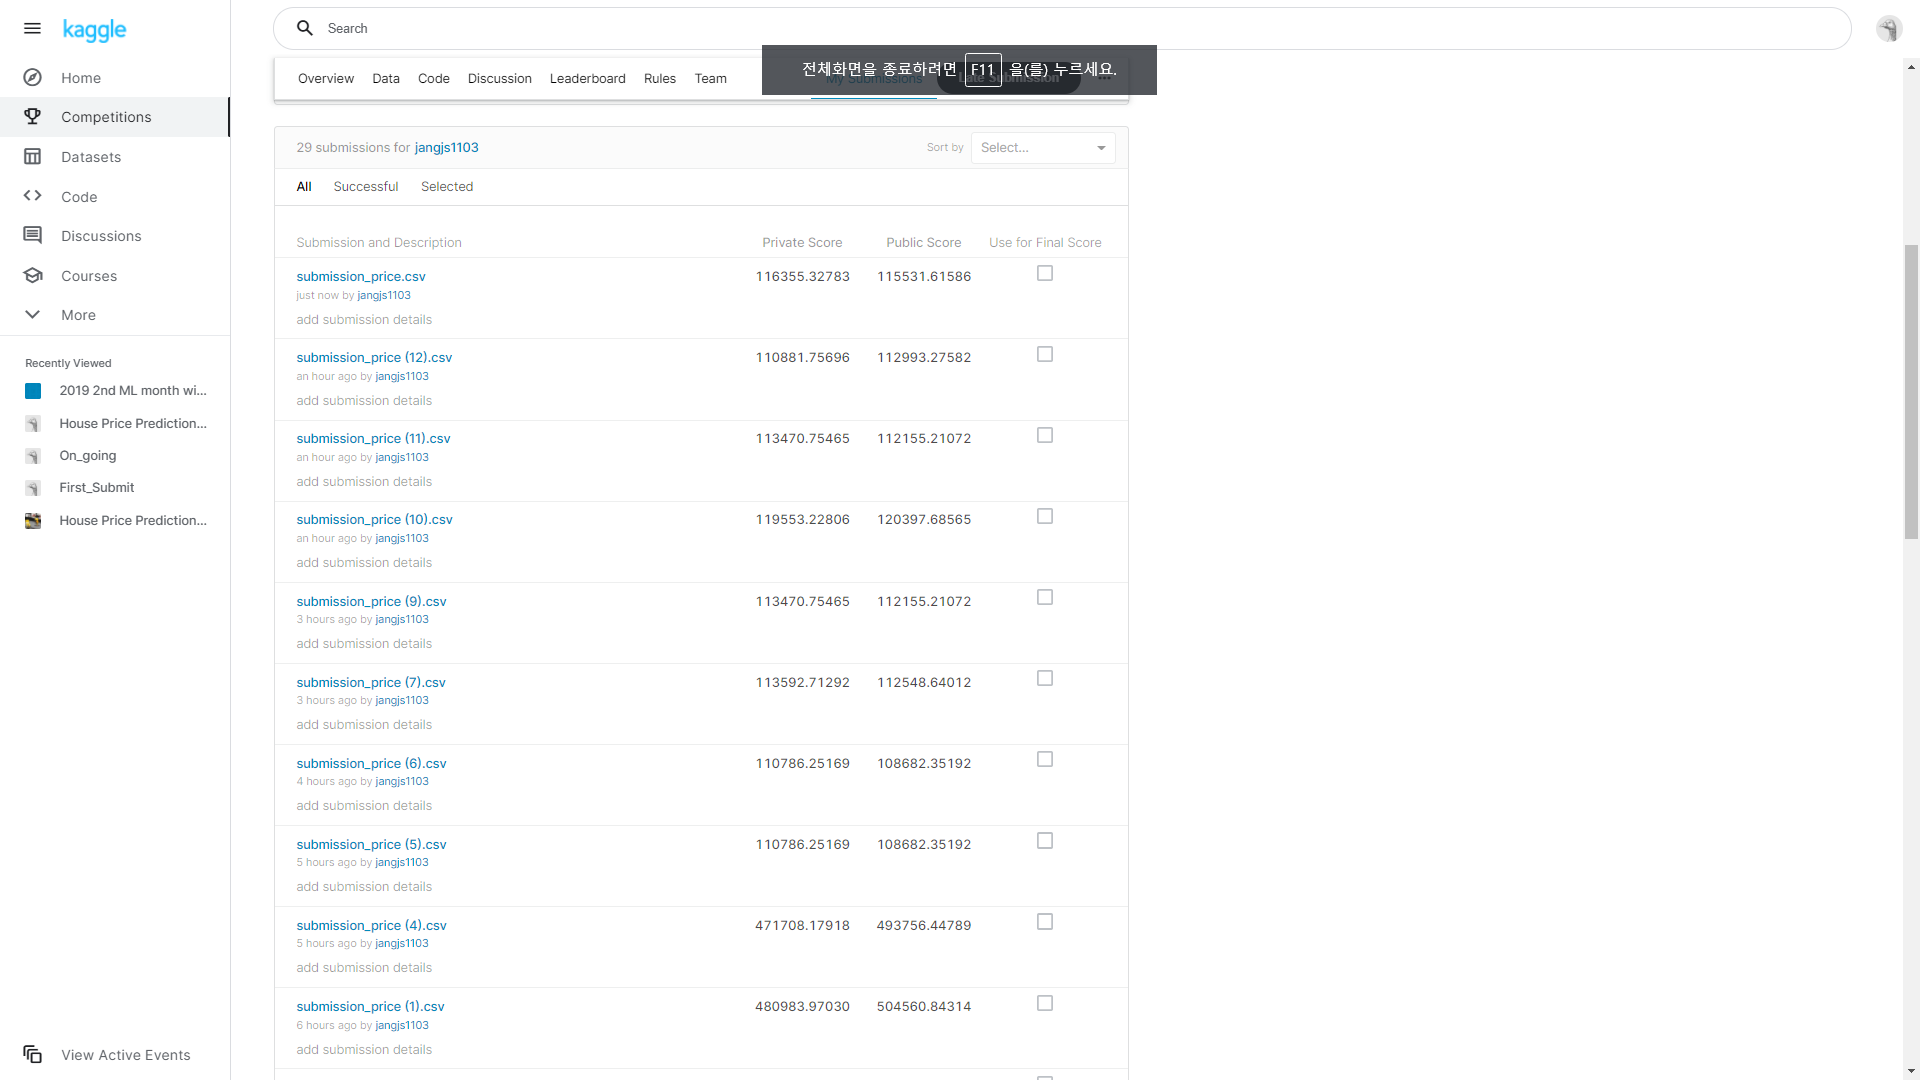

### 회고
* private score를 최대 110300 정도 까지는 얻었는데 110000 이하의 스코어는 얻지 못했다.
* 전체 방의 갯수, 평당 가격, 집코드에 따른 가격 등을 변수로 활용하여 마찬가지로 진행을 해봤었지만 역시나 목표 스코어를 얻지 못했다.
* 좀 더 여러가지 방식으로 변수를 조합하여 시도해 볼 필요가 있었다고 생각한다.
* 하이퍼 파라미터의 설정 또한 여러 조합을 시도해 볼 필요가 있었다.